In [2]:
%matplotlib inline

import IPython

import openpifpaf
openpifpaf.show.Canvas.show = True

# WholeBody
<div style="text-align: right"> by <a href="https://www.linkedin.com/in/duncan-zauss/">Duncan Zauss</a>, 07/05/2021</div> <br />
This is an extension to OpenPifPaf to detect body, foot, face and hand keypoints, which sum up to 133 keypoints per person. Thus, this plugin is especially useful if fine-grained face, hand or foot keypoints are required. The annotations for these keypoints are taken from the <a href="https://github.com/jin-s13/COCO-WholeBody">COCO WholeBody dataset</a>.

## Prediction
We provide two pretrained models for predicting the 133 keypoints of the COCO WholeBody dataset. The models can be called with `--checkpoint=shufflenetv2k16-wholebody` or `--checkpoint=shufflenetv2k30-wholebody`. Below an example prediction is shown.

In [3]:
%%bash
python -m openpifpaf.predict wholebody/soccer.jpeg \
    --checkpoint=shufflenetv2k30-wholebody --line-width=2 --image-output

INFO:__main__:neural network device: cuda (CUDA available: True, count: 1)
INFO:openpifpaf.predictor:neural network device: cuda (CUDA available: True, count: 1)
INFO:openpifpaf.decoder.cifcaf:2 annotations: [130, 133]
INFO:openpifpaf.predictor:batch 0: wholebody/soccer.jpeg


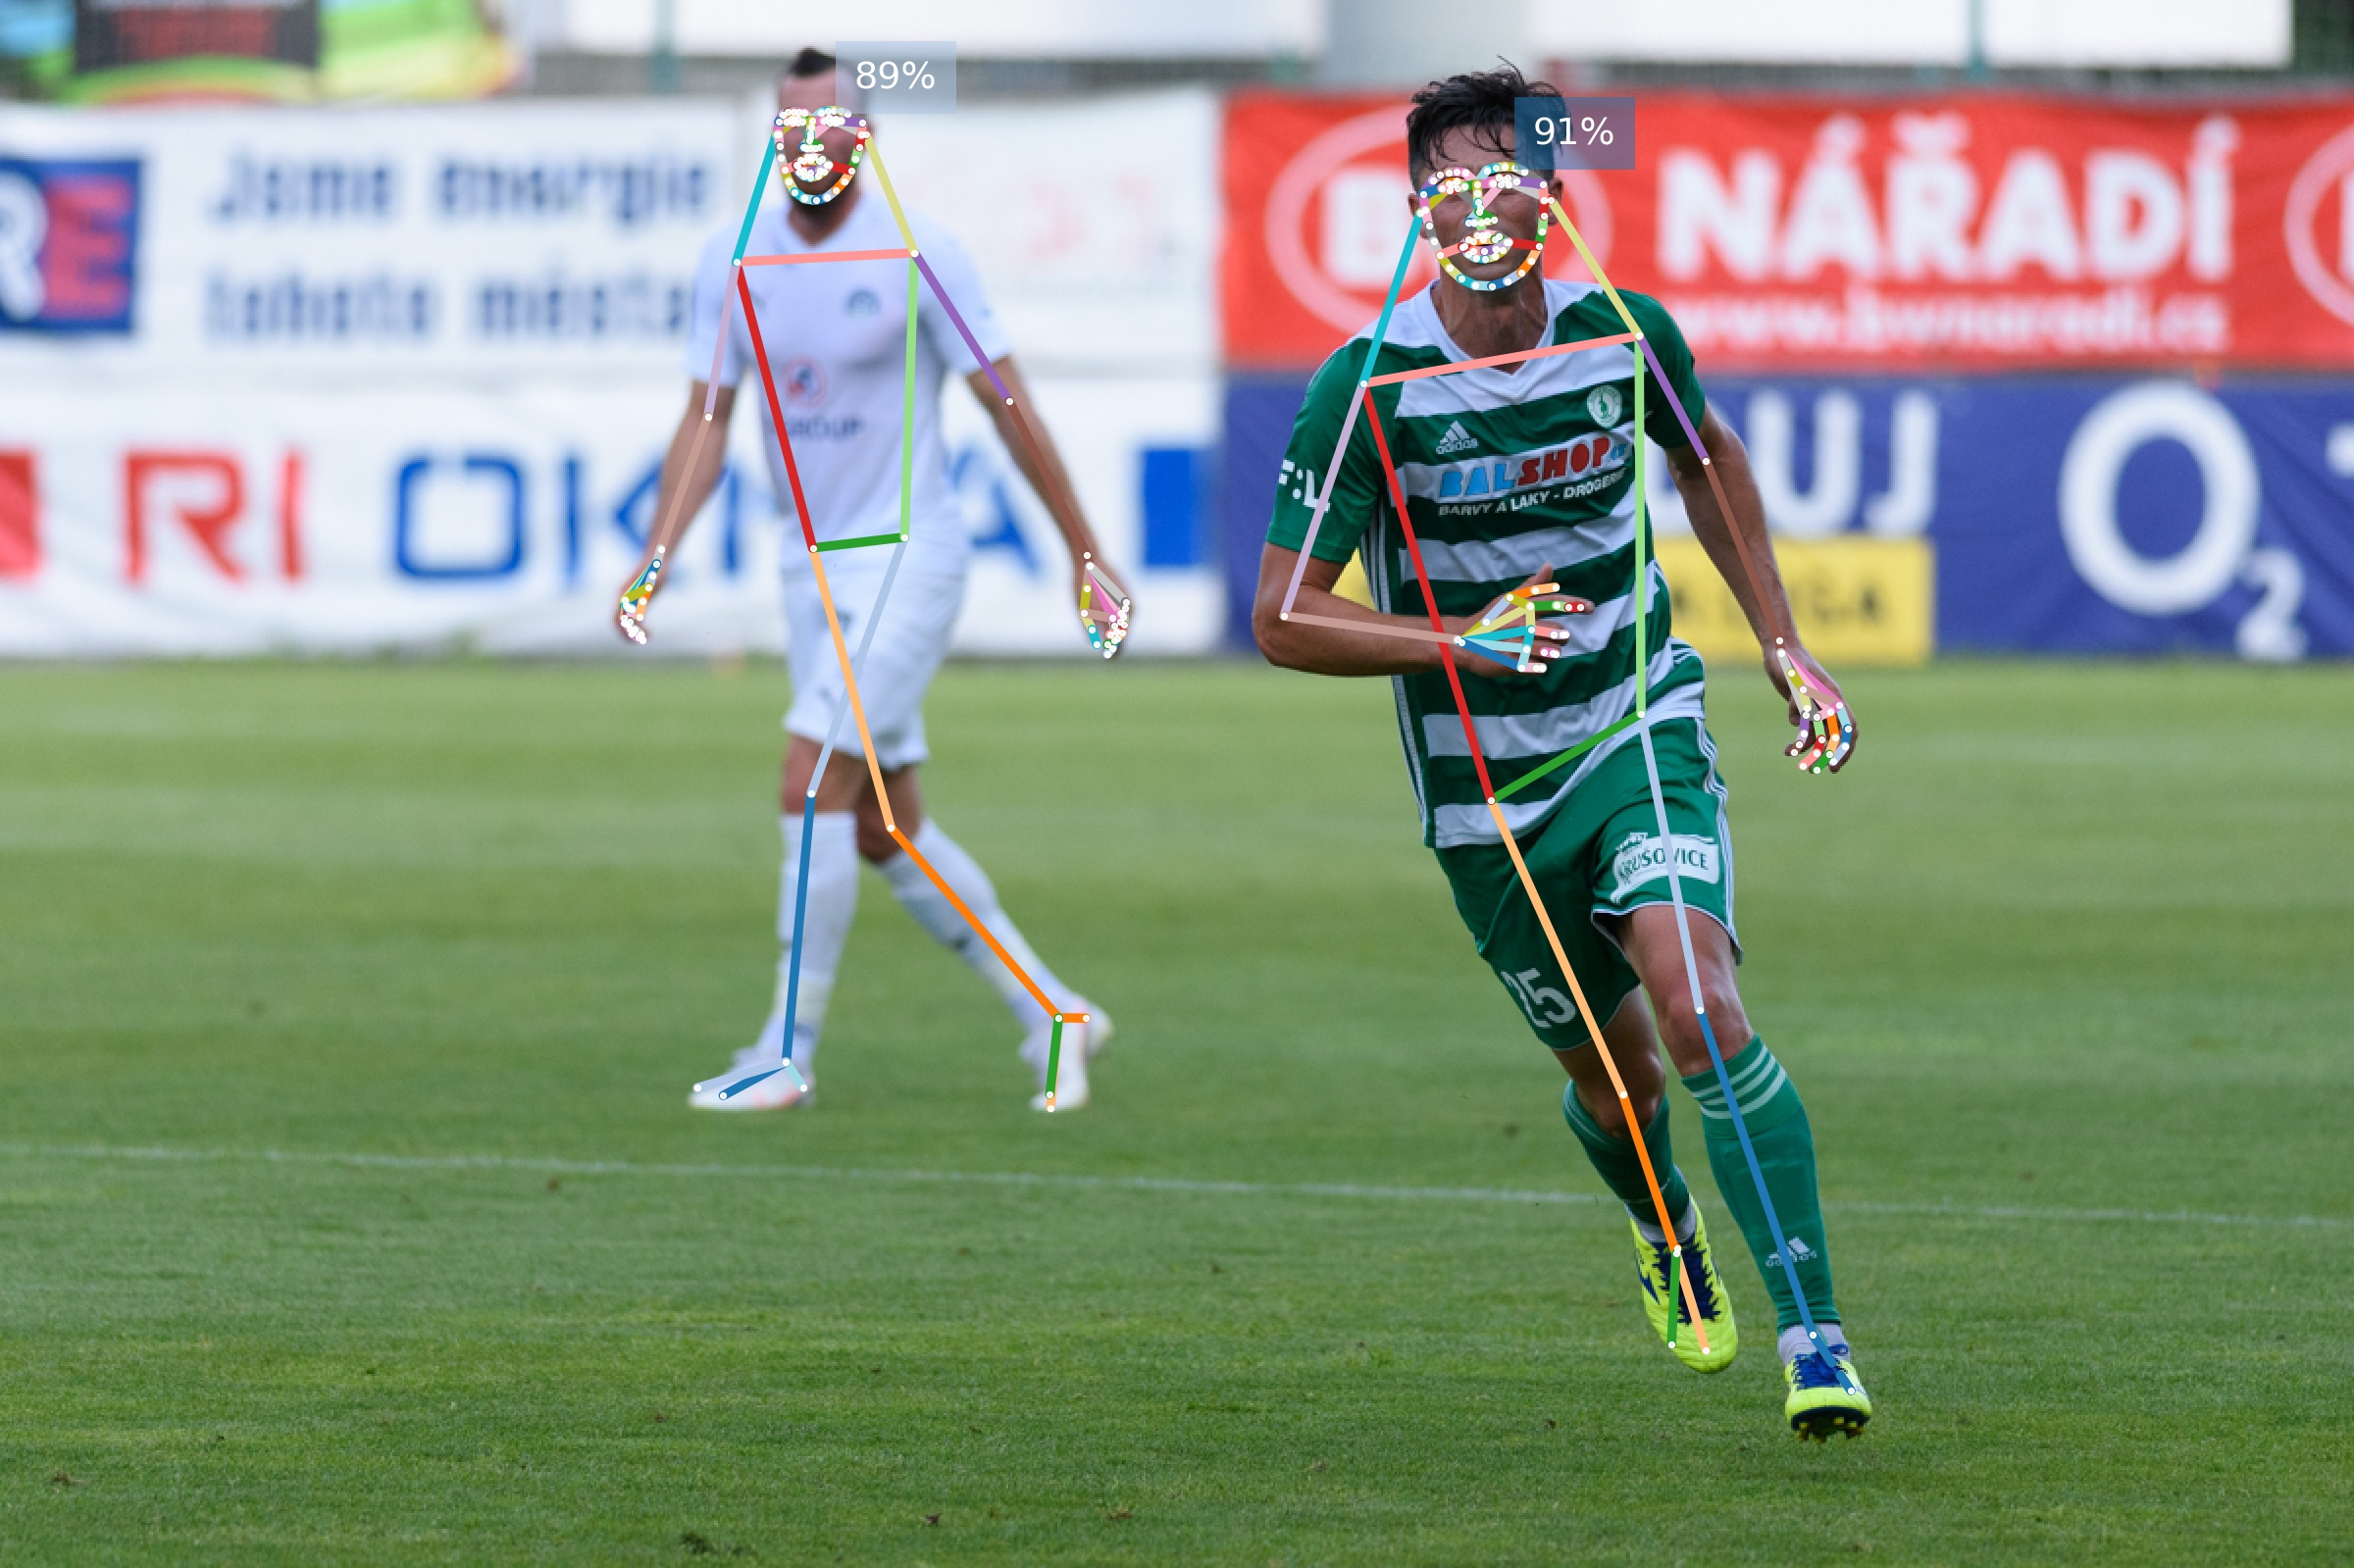

In [4]:
IPython.display.Image('wholebody/soccer.jpeg.predictions.jpeg')

Image credit: [Photo](https://de.wikipedia.org/wiki/Kamil_Vacek#/media/Datei:Kamil_Vacek_20200627.jpg) by [Lokomotive74](https://commons.wikimedia.org/wiki/User:Lokomotive74) which is licensed under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/).

## Visualization of the additional keypoints
Original MS COCO skeleton / COCO WholeBody skeleton

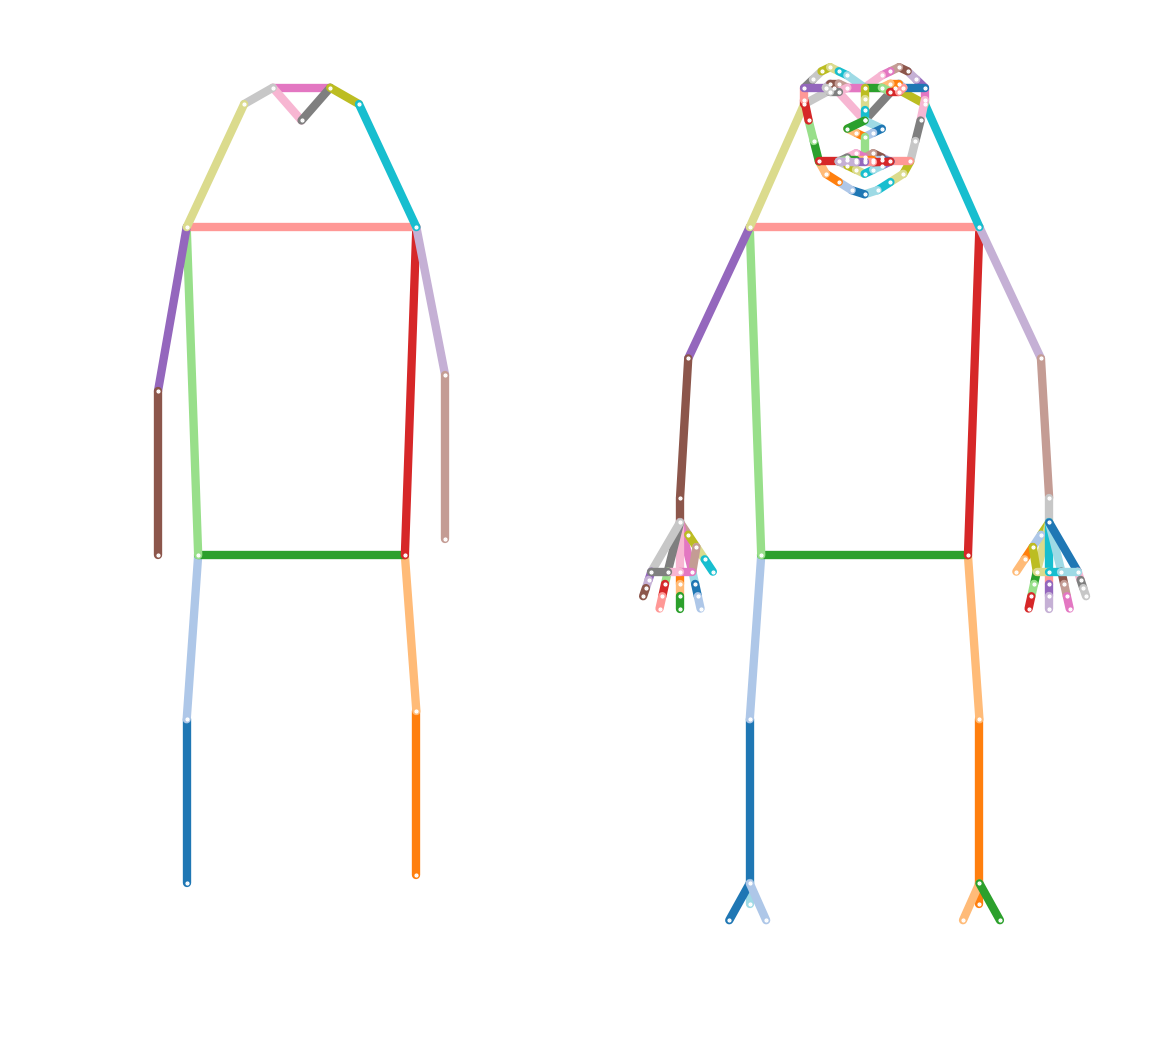

In [5]:
# HIDE CODE

# first make an annotation
ann_coco = openpifpaf.Annotation.from_cif_meta(
    openpifpaf.plugins.coco.CocoKp().head_metas[0])
ann_wholebody = openpifpaf.Annotation.from_cif_meta(
    openpifpaf.plugins.wholebody.Wholebody().head_metas[0])

# visualize the annotation
openpifpaf.show.KeypointPainter.show_joint_scales = False
openpifpaf.show.KeypointPainter.line_width = 3
keypoint_painter = openpifpaf.show.KeypointPainter()
with openpifpaf.show.Canvas.annotation(ann_wholebody, ncols=2) as (ax1, ax2):
    keypoint_painter.annotation(ax1, ann_coco)
    keypoint_painter.annotation(ax2, ann_wholebody)

## Train
If you don't want to use the pre-trained model, you can train a model from scratch.
To train you first need to download the wholebody into your MS COCO dataset folder:
```
wget https://github.com/DuncanZauss/openpifpaf_assets/releases/download/v0.1.0/person_keypoints_train2017_wholebody_pifpaf_style.json -O /<PathToYourMSCOCO>/data-mscoco/annotations
wget https://github.com/DuncanZauss/openpifpaf_assets/releases/download/v0.1.0/person_keypoints_val2017_wholebody_pifpaf_style.json -O /<PathToYourMSCOCO>/data-mscoco/annotations
```
Note: The pifpaf style annotation files were create with [Get_annotations_from_coco_wholebody.py](https://github.com/openpifpaf/openpifpaf/blob/main/openpifpaf/plugins/wholebody/helper_scripts/Get_annotations_from_coco_wholebody.py). If you want to create your own annotation files from coco wholebody, you need to download the original files from the [COCO WholeBody page](https://github.com/jin-s13/COCO-WholeBody#download) and then create the pifpaf readable json files with [Get_annotations_from_coco_wholebody.py](https://github.com/openpifpaf/openpifpaf/blob/main/openpifpaf/plugins/wholebody/helper_scripts/Get_annotations_from_coco_wholebody.py). This can be useful if you for example only want to use a subset of images for training.

Finally you can train the model (Note: This can take several days, even on the good GPUs):<br/>
```
python3 -m openpifpaf.train --lr=0.0001 --momentum=0.95 --b-scale=3.0 --epochs=150 --lr-decay 130 140 --lr-decay-epochs=10 --batch-size=16 --weight-decay=1e-5 --dataset=wholebody --wholebody-upsample=2 --basenet=shufflenetv2k16 --loader-workers=16 --wholebody-train-annotations=<PathToYourMSCOCO>/data-mscoco/annotations/person_keypoints_train2017_wholebody_pifpaf_style.json --wholebody-val-annotations=<PathToYourMSCOCO>/data-mscoco/annotations/person_keypoints_val2017_wholebody_pifpaf_style.json --wholebody-train-image-dir=<COCO_train_image_dir> --wholebody-val-image-dir=<COCO_val_image_dir>
```

## Evaluation
To evaluate your network you can use the following command. Important note: For evaluation you will need the original [validation annotation file from COCO WholeBody](https://drive.google.com/file/d/1N6VgwKnj8DeyGXCvp1eYgNbRmw6jdfrb/view), which has a different format than the files that are used for training. We use this different annotation format as we use the [extended pycocotools](https://github.com/jin-s13/xtcocoapi) for evaluation as proposed by the authors of COCO WholeBody. You can run the evaluation with:<br/>
```
python3 -m openpifpaf.eval --dataset=wholebody --checkpoint=shufflenetv2k16-wholebody --force-complete-pose --seed-threshold=0.2 --loader-workers=16 --wholebody-val-annotations=<PathToTheOriginalCOCOWholeBodyAnnotations>/coco_wholebody_val_v1.0.json --wholebody-val-image-dir=<COCO_val_image_dir>
```

## Using only a subset of keypoints
If you only want to train on a subset of keypoints, e.g. if you do not need the facial keypoints and only want to train on the body, foot and hand keypoints, it should be fairly easy to just train on this subset. You will need to:
- Download the original annotation files from the [Coco Whole body page](https://github.com/jin-s13/COCO-WholeBody#download). Create a new annotations file with [Get_annotations_from_coco_wholebody.py](https://github.com/openpifpaf/openpifpaf/blob/main/openpifpaf/plugins/wholebody/helper_scripts/Get_annotations_from_coco_wholebody.py). Set `ann_types`to the keypoints that you would like to use and create the train and val json file. You can use [Visualize_annotations.py](https://github.com/openpifpaf/openpifpaf/blob/main/openpifpaf/plugins/wholebody/helper_scripts/Visualize_annotations.py.py) to verify that the json file was created correctly.
- In the [constants.py](https://github.com/openpifpaf/openpifpaf/blob/main/openpifpaf/plugins/wholebody/constants.py) file comment out all the parts of the skeleton, pose, HFLIP, SIGMA and keypoint names that you do not need. All these constants are already split up in the body parts. The numbering of the joints may now be different (e.g. when you discard the face kpts, but keep the hand kpts), so you need to adjust the numbers in the skeleton definitions to be consisten with the new numbering of the joints.
- That's it! You can train the model with a subset of keypoints.
